In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
nltk.download('punkt')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer

import os
from collections import Counter


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ilonakopincu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")

elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f"Using MPS: {torch.backends.mps.is_available()}")
else:
    device = torch.device('cpu')
print(f'Using device: {device}')


Using MPS: True
Using device: mps


In [ ]:
data = pd.read_csv("Train_rev1.csv", index_col=None)
print(f"Data shape: {data.shape}")
data.head()


Data shape: (244768, 12)


,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


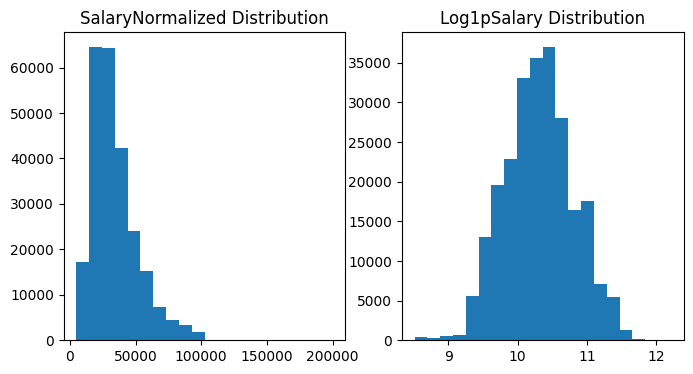

In [ ]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20)
plt.title('SalaryNormalized Distribution')

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20)
plt.title('Log1pSalary Distribution')
plt.show()


In [ ]:
data["Title"] = data["Title"].fillna('')
data["FullDescription"] = data["FullDescription"].fillna('')

tokenizer = nltk.tokenize.WordPunctTokenizer()

def tokenize_text(text):
    tokens = tokenizer.tokenize(text.lower())
    return ' '.join(tokens)

data["Title"] = data["Title"].apply(tokenize_text)
data["FullDescription"] = data["FullDescription"].apply(tokenize_text)

print("Tokenized FullDescription sample:")
print(data["FullDescription"].iloc[2][:100])


Tokenized FullDescription sample:
mathematical modeller / simulation analyst / operational analyst basingstoke , hampshire up to **** 


In [ ]:
token_counts = Counter()

for text in data["FullDescription"]:
    tokens = text.split()
    token_counts.update(tokens)

print(f"Total unique tokens: {len(token_counts)}")


Total unique tokens: 199713


In [ ]:
min_count = 5

tokens = [token for token, count in token_counts.items() if count >= min_count]

UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

token_to_id = {token: idx for idx, token in enumerate(tokens)}

print(f"Vocabulary size: {len(token_to_id)}")


Vocabulary size: 49508


In [ ]:
import os
import requests
import zipfile

glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_dir = "glove_data"

if not os.path.exists(glove_dir):
    os.makedirs(glove_dir)

glove_zip_path = os.path.join(glove_dir, "glove.6B.zip")
if not os.path.exists(glove_zip_path):
    print("Downloading GloVe embeddings...")
    response = requests.get(glove_url, stream=True)
    with open(glove_zip_path, "wb") as f:
        f.write(response.content)
    print("Download complete.")

with zipfile.ZipFile(glove_zip_path, "r") as zip_ref:
    zip_ref.extractall(glove_dir)
    print("Extraction complete.")


In [ ]:
embedding_dim = 100
glove_path = 'glove.6B.100d.txt'

embeddings_index = {}

with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f'Total word vectors in GloVe: {len(embeddings_index)}')


Total word vectors in GloVe: 400000


In [ ]:
embedding_matrix = np.zeros((len(tokens), embedding_dim))

for word, idx in token_to_id.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))


In [ ]:
UNK_IX, PAD_IX = token_to_id[UNK], token_to_id[PAD]

def as_matrix(sequences, max_len=None):
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float('inf'))

    matrix = np.full((len(sequences), max_len), PAD_IX, dtype=np.int32)
    for i, seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix


In [ ]:
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]

data[categorical_columns] = data[categorical_columns].fillna('NaN')

top_companies = data['Company'].value_counts().index[:1000]
data['Company'] = data['Company'].apply(lambda x: x if x in top_companies else 'Other')

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

print(f"Categorical features dimension: {len(categorical_vectorizer.vocabulary_)}")


Categorical features dimension: 3768


In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=5)

tfidf_vectorizer.fit(data["FullDescription"])

tfidf_full = tfidf_vectorizer.transform(data["FullDescription"])

tfidf_size = tfidf_full.shape[1]
print(f"TF-IDF features dimension: {tfidf_size}")


TF-IDF features dimension: 5000


In [ ]:
data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.reset_index(drop=True, inplace=True)
data_val.reset_index(drop=True, inplace=True)

print(f"Training samples: {len(data_train)}")
print(f"Validation samples: {len(data_val)}")


Training samples: 195814
Validation samples: 48954


In [ ]:
def to_tensors(batch, device):
    batch_tensors = {}
    for key, arr in batch.items():
        if key in ["Title", "FullDescription"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.long)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.float32)
    return batch_tensors


In [ ]:
def make_batch(data_batch, max_len=None, device=device):
    batch = {}
    batch["Title"] = as_matrix(data_batch["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data_batch["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data_batch[categorical_columns].apply(dict, axis=1))
    batch['TFIDF'] = tfidf_vectorizer.transform(data_batch["FullDescription"]).toarray()

    if 'Log1pSalary' in data_batch.columns:
        batch['Log1pSalary'] = data_batch['Log1pSalary'].values

    return to_tensors(batch, device)


In [ ]:
def iterate_minibatches(data, batch_size=256, shuffle=True, device=device):
    indices = np.arange(len(data))
    if shuffle:
        np.random.shuffle(indices)
    for start_idx in range(0, len(data), batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]
        batch_data = data.iloc[excerpt]
        yield make_batch(batch_data, device=device)


In [ ]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens, embedding_dim, embedding_matrix, n_cat_features, tfidf_size, hid_size=64, dropout_prob=0.5):
        super(SalaryPredictor, self).__init__()

        self.embedding = nn.Embedding(n_tokens, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False

        self.dropout = nn.Dropout(dropout_prob)

        self.title_conv = nn.Conv1d(embedding_dim, hid_size, kernel_size=3, padding=1)
        self.title_bilstm = nn.LSTM(hid_size, hid_size, batch_first=True, bidirectional=True)

        self.desc_conv = nn.Conv1d(embedding_dim, hid_size, kernel_size=3, padding=1)
        self.desc_bilstm = nn.LSTM(hid_size, hid_size, batch_first=True, bidirectional=True)

        self.cat_linear = nn.Linear(n_cat_features, hid_size)

        self.tfidf_linear = nn.Linear(tfidf_size, hid_size)

        self.fc = nn.Sequential(
            nn.Linear(hid_size * 6, hid_size * 2),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hid_size * 2, 1)
        )

    def forward(self, batch):
        title_emb = self.embedding(batch['Title'])
        desc_emb = self.embedding(batch['FullDescription'])

        title_emb = title_emb.permute(0, 2, 1)
        title_conv_out = self.title_conv(title_emb)
        title_conv_out = self.dropout(title_conv_out)
        title_conv_out = title_conv_out.permute(0, 2, 1)
        title_bilstm_out, _ = self.title_bilstm(title_conv_out)
        title_bilstm_out = self.dropout(title_bilstm_out)
        title_features = torch.max(title_bilstm_out, dim=1)[0]

        desc_emb = desc_emb.permute(0, 2, 1)
        desc_conv_out = self.desc_conv(desc_emb)
        desc_conv_out = self.dropout(desc_conv_out)
        desc_conv_out = desc_conv_out.permute(0, 2, 1)
        desc_bilstm_out, _ = self.desc_bilstm(desc_conv_out)
        desc_bilstm_out = self.dropout(desc_bilstm_out)
        desc_features = torch.max(desc_bilstm_out, dim=1)[0]

        cat_features = self.cat_linear(batch['Categorical'])

        tfidf_features = self.tfidf_linear(batch['TFIDF'])

        combined_features = torch.cat([title_features, desc_features, cat_features, tfidf_features], dim=1)

        output = self.fc(combined_features).squeeze(1)

        return output

In [ ]:
n_tokens = len(tokens)
embedding_dim = embedding_matrix.shape[1]
n_cat_features = len(categorical_vectorizer.vocabulary_)
hid_size = 64

model = SalaryPredictor(
    n_tokens=n_tokens,
    embedding_dim=embedding_dim,
    embedding_matrix=embedding_matrix,
    n_cat_features=n_cat_features,
    tfidf_size=tfidf_size,
    hid_size=hid_size
).to(device)

print(model)


SalaryPredictor(
  (embedding): Embedding(49508, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (title_conv): Conv1d(100, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (title_bilstm): LSTM(64, 64, batch_first=True, bidirectional=True)
  (desc_conv): Conv1d(100, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (desc_bilstm): LSTM(64, 64, batch_first=True, bidirectional=True)
  (cat_linear): Linear(in_features=3768, out_features=64, bias=True)
  (tfidf_linear): Linear(in_features=5000, out_features=64, bias=True)
  (fc): Sequential(
    (0): Linear(in_features=384, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [ ]:
def save_checkpoint(model, optimizer, epoch, loss, path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved at {path}")

def load_checkpoint(model, optimizer, path):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded from {path}")
    return epoch, loss


In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
num_epochs = 10
batch_size = 32
best_val_loss = float('inf')
model_dir = 'model_checkpoints'
os.makedirs(model_dir, exist_ok=True)

start_epoch = 1
checkpoint_path = os.path.join(model_dir, 'last_checkpoint.pth')
if os.path.exists(checkpoint_path):
    start_epoch, _ = load_checkpoint(model, optimizer, checkpoint_path)
    start_epoch += 1

for epoch in range(start_epoch, num_epochs + 1):
    model.train()
    total_loss = 0
    total_mae = 0
    total_samples = 0

    train_batches = list(iterate_minibatches(data_train, batch_size=batch_size, shuffle=True, device=device))
    num_batches = len(train_batches)

    for batch_idx, batch in enumerate(train_batches):
        optimizer.zero_grad()

        outputs = model(batch)
        loss = criterion(outputs, batch['Log1pSalary'])
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_mae += torch.sum(torch.abs(outputs - batch['Log1pSalary'])).item()
        total_samples += len(batch['Log1pSalary'])

        if (batch_idx + 1) % (num_batches // 10) == 0:
            progress = (batch_idx + 1) / num_batches * 100
            print(f'Epoch [{epoch}/{num_epochs}] - {progress:.2f}% completed')

    avg_train_loss = total_loss / num_batches
    avg_train_mae = total_mae / total_samples
    print(f'Epoch [{epoch}/{num_epochs}] - Average Training Loss: {avg_train_loss:.4f}, Average Training MAE (log): {avg_train_mae:.4f}')

    checkpoint_path = os.path.join(model_dir, 'last_checkpoint.pth')
    save_checkpoint(model, optimizer, epoch, avg_train_loss, checkpoint_path)

    model.eval()
    val_loss = 0
    val_mae = 0
    total_val_samples = 0

    val_batches = list(iterate_minibatches(data_val, batch_size=batch_size, shuffle=False, device=device))

    with torch.no_grad():
        for val_batch in val_batches:
            outputs = model(val_batch)
            loss = criterion(outputs, val_batch['Log1pSalary'])
            val_loss += loss.item()

            val_mae += torch.sum(torch.abs(outputs - val_batch['Log1pSalary'])).item()
            total_val_samples += len(val_batch['Log1pSalary'])

    avg_val_loss = val_loss / len(val_batches)
    avg_val_mae = val_mae / total_val_samples
    print(f'Validation Loss: {avg_val_loss:.4f}, Validation MAE (log): {avg_val_mae:.4f}')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_path = os.path.join(model_dir, 'best_model.pth')
        save_checkpoint(model, optimizer, epoch, avg_val_loss, best_model_path)
        print('Best model saved.')


Epoch [1/10] - 10.00% completed
Epoch [1/10] - 20.00% completed
Epoch [1/10] - 30.00% completed
Epoch [1/10] - 40.00% completed
Epoch [1/10] - 50.00% completed
Epoch [1/10] - 60.00% completed
Epoch [1/10] - 70.00% completed
Epoch [1/10] - 80.00% completed
Epoch [1/10] - 90.00% completed
Epoch [1/10] - 100.00% completed
Epoch [1/10] - Average Training Loss: 1.0918, Average Training MAE (log): 0.8285
Checkpoint saved at model_checkpoints/last_checkpoint.pth
Validation Loss: 13.2130, Validation MAE (log): 3.6224
Checkpoint saved at model_checkpoints/best_model.pth
Best model saved.
Epoch [2/10] - 10.00% completed
Epoch [2/10] - 20.00% completed
Epoch [2/10] - 30.00% completed
Epoch [2/10] - 40.00% completed
Epoch [2/10] - 50.00% completed
Epoch [2/10] - 60.00% completed
Epoch [2/10] - 70.00% completed
Epoch [2/10] - 80.00% completed
Epoch [2/10] - 90.00% completed
Epoch [2/10] - 100.00% completed
Epoch [2/10] - Average Training Loss: 0.4884, Average Training MAE (log): 0.5505
Checkpoint s

In [ ]:
num_epochs = 30
batch_size = 32
best_val_loss = float('inf')
model_dir = 'model_checkpoints'
os.makedirs(model_dir, exist_ok=True)

start_epoch = 1
checkpoint_path = os.path.join(model_dir, 'last_checkpoint.pth')
if os.path.exists(checkpoint_path):
    start_epoch, _ = load_checkpoint(model, optimizer, checkpoint_path)
    start_epoch += 1

for epoch in range(start_epoch, num_epochs + 1):
    model.train()
    total_loss = 0
    total_mae = 0
    total_samples = 0

    train_batches = list(iterate_minibatches(data_train, batch_size=batch_size, shuffle=True, device=device))
    num_batches = len(train_batches)

    for batch_idx, batch in enumerate(train_batches):
        optimizer.zero_grad()

        outputs = model(batch)
        loss = criterion(outputs, batch['Log1pSalary'])
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_mae += torch.sum(torch.abs(outputs - batch['Log1pSalary'])).item()
        total_samples += len(batch['Log1pSalary'])

        if (batch_idx + 1) % (num_batches // 10) == 0:
            progress = (batch_idx + 1) / num_batches * 100
            print(f'Epoch [{epoch}/{num_epochs}] - {progress:.2f}% completed')

    avg_train_loss = total_loss / num_batches
    avg_train_mae = total_mae / total_samples
    print(f'Epoch [{epoch}/{num_epochs}] - Average Training Loss: {avg_train_loss:.4f}, Average Training MAE (log): {avg_train_mae:.4f}')

    checkpoint_path = os.path.join(model_dir, 'last_checkpoint.pth')
    save_checkpoint(model, optimizer, epoch, avg_train_loss, checkpoint_path)

    model.eval()
    val_loss = 0
    val_mae = 0
    total_val_samples = 0

    val_batches = list(iterate_minibatches(data_val, batch_size=batch_size, shuffle=False, device=device))

    with torch.no_grad():
        for val_batch in val_batches:
            outputs = model(val_batch)
            loss = criterion(outputs, val_batch['Log1pSalary'])
            val_loss += loss.item()

            val_mae += torch.sum(torch.abs(outputs - val_batch['Log1pSalary'])).item()
            total_val_samples += len(val_batch['Log1pSalary'])

    avg_val_loss = val_loss / len(val_batches)
    avg_val_mae = val_mae / total_val_samples
    print(f'Validation Loss: {avg_val_loss:.4f}, Validation MAE (log): {avg_val_mae:.4f}')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_path = os.path.join(model_dir, 'best_model.pth')
        save_checkpoint(model, optimizer, epoch, avg_val_loss, best_model_path)
        print('Best model saved.')

/var/folders/q_/9fy4_qr97kz6z5ph21c3b6yc0000gq/T/ipykernel_19189/719790932.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=de

Checkpoint loaded from model_checkpoints/last_checkpoint.pth
Epoch [11/30] - 10.00% completed
Epoch [11/30] - 20.00% completed
Epoch [11/30] - 30.00% completed
Epoch [11/30] - 40.00% completed
Epoch [11/30] - 50.00% completed
Epoch [11/30] - 60.00% completed
Epoch [11/30] - 70.00% completed
Epoch [11/30] - 80.00% completed
Epoch [11/30] - 90.00% completed
Epoch [11/30] - 100.00% completed
Epoch [11/30] - Average Training Loss: 0.0819, Average Training MAE (log): 0.2149
Checkpoint saved at model_checkpoints/last_checkpoint.pth
Validation Loss: 0.1287, Validation MAE (log): 0.2838
Checkpoint saved at model_checkpoints/best_model.pth
Best model saved.
Epoch [12/30] - 10.00% completed
Epoch [12/30] - 20.00% completed
Epoch [12/30] - 30.00% completed
Epoch [12/30] - 40.00% completed
Epoch [12/30] - 50.00% completed
Epoch [12/30] - 60.00% completed
Epoch [12/30] - 70.00% completed
Epoch [12/30] - 80.00% completed
Epoch [12/30] - 90.00% completed
Epoch [12/30] - 100.00% completed
Epoch [12/30